## Trying out the 1D functionality of MEEP

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import shutil

import meep as mp

import sys
sys.path.append('../../jupyter-meep-libs')
import meep_nb as mpnb

## Define the susceptibility

In [38]:
freq_21 = 1 / 1.218
omega_a = freq_21 * (2 * np.pi)                           # omega_a in SALT

gamma_perp = 2                         # HWHM in angular frequency, SALT
gamma_21 = (2*gamma_perp)/(2*np.pi)  # FWHM emission linewidth in sec^-1 (units of 2πc/a)

theta = 1                              # theta, the off-diagonal dipole matrix element, in SALT
sigma_21 = 2*theta*theta*omega_a       # dipole coupling strength (hbar = 1)

# Gain medium pump and decay rates are specified in units of c/a.
rate_21 = 0.005        # non-radiative rate  (units of c/a)
N0 = 3                # initial population density of ground state
Rp = rate_21 + 6e-3            # pumping rate of ground to excited state

# Make the actual medium in MEEP:
transitions = [mp.Transition(1, 2, pumping_rate=Rp, frequency=freq_21, gamma=gamma_21,
                             sigma_diag=mp.Vector3(0,sigma_21,0)),
               mp.Transition(2, 1, transition_rate=rate_21)]
ml_atom = mp.MultilevelAtom(sigma=1, transitions=transitions, initial_populations=[N0])
two_level = mp.Medium(index=2.5, E_susceptibilities=[ml_atom], D_conductivity=.2)

In [42]:
cell = mp.Vector3(50, 0, 0)
background = mp.Block(mp.Vector3(cell.x, mp.inf, mp.inf),
                     center=mp.Vector3(0),
                     material=mp.Medium(index=2.5, D_conductivity=.05))
ampsection = mp.Block(mp.Vector3(1.218/2.5*60.5, mp.inf, mp.inf), center=mp.Vector3(0), material=two_level)
geometry = [background, ampsection]

dpml = 2.
pml_layers = [mp.PML(dpml)]

fcen = 1 / 1.218
df = fcen / 3
sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df, start_time=250), 
                     component=mp.Ey,
                     center=mp.Vector3(-cell.x / 2 + dpml)),
#           mp.Source(mp.GaussianSource(1/4, fwidth=df, start_time=250), 
#                      component=mp.Ey,
#                      center=mp.Vector3(-cell.x / 2 + dpml)),
          ]

resolution = 30

In [50]:
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution,
                    symmetries=[],
                    progress_interval=1e6)

sim.init_sim()

def field_func(p):
    return 1e0*np.random.randn() if np.abs(p.x) < 20 else 0

# sim.fields.initialize_field(mp.Ey, field_func)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000164986 s
Working in 2D dimensions.
Computational cell is 50 x 0.0333333 x 0 with resolution 30
     block, center = (0,0,0)
          size (50,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (0,0,0)
          size (29.4756,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
time for set_epsilon = 0.0108891 s
time for set_conductivity = 0.000309944 s
time for set_conductivity = 0.000359058 s
time for set_conductivity = 0.000347137 s
multilevel atom susceptibility
-----------


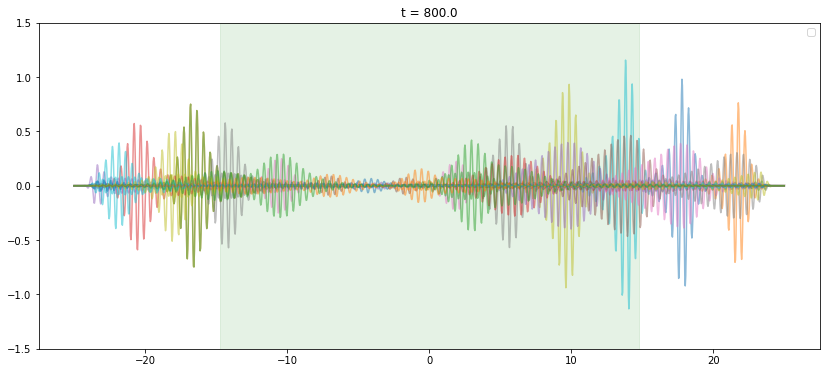

run 3 finished at t = 800.0 (48000 timesteps)
--Return--
[28] > <ipython-input-53-44b8911f82a6>(14)plot_sim()->None
-> until=until)
(ant-pdb++) c


Text(3.200000000000017, 0.5, 'Efield')

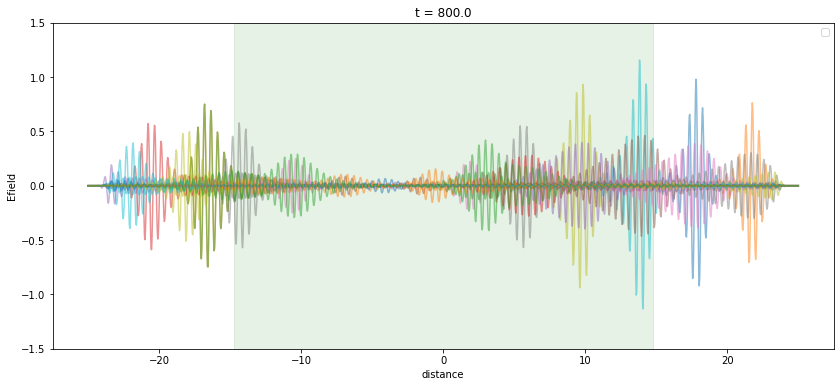

In [53]:
def livefield(sim):
    plt.plot(*mpnb.x_field_data(sim, mp.Ey), alpha=.5)
    mpnb.liveplot_1D(sim, mp.Ey)
    
def plot_sim(until=200):
#     sim.reset_meep()
    livefield(sim)
    sim.run(until=200)
#     sim.change_sources(sources)
    import pdb; pdb.set_trace()
    sim.run(
            mp.at_beginning(livefield),
            mp.at_every(10, livefield),
            until=until)

    
fig = plt.figure(figsize=(14,6))
plt.axvspan(-ampsection.size.x/2, ampsection.size.x/2, color='g', alpha=0.1)
plt.ylim(-1.5, 1.5)
plot_sim(200)
plt.xlabel('distance')
plt.ylabel('Efield')

In [ ]:
import pdf